# Brands and Product Emotions

**Authors:** Kevin McDonough, Brad Horn, Ryan Reilly

![title](images/twitter_4.jpeg)

## Overview

This project analyzes data for over 9,000 tweets about product reviews for Apple and Google. Human raters rated the sentiment as positive, negative, or neither. The goal of this analysis is to build an NLP model that will accurately predict the sentiment of a tweet based on the tweets text. This will be done through exploratory data analysis and iterative predictive modeling using classification models. 

## Business Problem

Apple and Google have hired us to predict the sentiment of tweets about theit products. They will use our analysis to gather critical feedback about problems in newly released products. Based on our analysis, we are going to provide reccomendations based on the following.

- Which products to manage based on negative tweets
- What people say most often about negative tweets
- 

## Data Understanding

Each row in this dataset represents a unique tweet made a by a user about an Apple or Google procduct. There are three columns in the dataset. Each feature and its description is listed below.

| Feature | Description|
|:-------| :-------|
|tweet_text| The full text of the tweet|
|emotion_in_tweet_is_directed_at| The product the tweet is directed at|
is_there_an_emotion_directed_at_a_brand_or_product| The sentiment label of the tweet in 4 classes (positive, negative, neutral, and I can't tell|

#### Importing packages and loading the datasets

In [47]:
#For data engineering
import pandas as pd
import numpy as np
import re
import string

#For visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
%matplotlib inline

#To scale and one-hot encode our columns
from sklearn.preprocessing import LabelEncoder

#To build all of our models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, sent_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams

#For counting words
import collections

#For Vectorizing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#Train test split, CV and Gridsearch
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

#To build our dummy model
from sklearn.dummy import DummyClassifier

#For evaluating our classification models
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report 
from sklearn.metrics import plot_roc_curve

#To apply oversampling for imbalanced dataset
from imblearn.over_sampling import SMOTE

#For building pipelines
from imblearn.pipeline import Pipeline as Pipeline

#to see how long a cell takes to run
import time

#Use the functions in the py file for preprocessing
import sys
#sys.path.insert(0, 'src/')
#import preprocessing

#To ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Stopwords
stop_words = set(stopwords.words('english'))

In [5]:
#Import the data
df = pd.read_csv('data/tweets.csv')

#Rename columns to get shorter clumn names
df.rename(columns={"tweet_text": "tweet",\
                   "emotion_in_tweet_is_directed_at":"product",\
                   "is_there_an_emotion_directed_at_a_brand_or_product": "sentiment"},\
          inplace=True)

In [6]:
#Take a look at the datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8721 entries, 0 to 8720
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      8720 non-null   object
 1   product    3169 non-null   object
 2   sentiment  8721 non-null   object
dtypes: object(3)
memory usage: 204.5+ KB


There looks to be nulls in the product column which we will have to deal with. We also may need to convert the tweet column to a string to be used for analysis.

In [7]:
#Take a look at the outcome variable and its value counts
df['sentiment'].value_counts().to_frame()

,sentiment
No emotion toward brand or product,5156
Positive emotion,2869
Negative emotion,545
I can't tell,151


THere are 4 classes for our target variable. There looks to be a good balance of no emotion(neutral) and postive tweets but there are few negative tweets so we will need to implement a re-sampling technique in our models. For those tweets that are labeld as I can't tell, we will remove these rows from the dataset for our analysis and modeling. 

## Data Preparation

### Handle Missing Values

In [8]:
#Create a dataframe with just those columns with NAs and there sums.
missing = pd.DataFrame(df.isna().sum(), columns = ['Nulls'])
#Label index column
missing.index.name = 'Feature'
#Just show the columns with missing data    
missing.sort_values(by=['Nulls'])

,Nulls
Feature,
sentiment,0
tweet,1
product,5552


#### We will remove the row with no tweet.

In [9]:
df = df[df['tweet'].notna()]

#### Impute Product Column

In [12]:
# Need to figure out a way to impute values in this column if possible

### Check for row duplicates and remove

In [10]:
print('Number of duplicates: {}'.format(len(df[df.duplicated()])))

Number of duplicates: 22


In [11]:
#Remove duplicates
df.drop_duplicates(inplace=True)

### Remove rows where the label is "I cant tell"

In [14]:
#Remove tweets with "I can't tell" sentiment
df = df[df.sentiment != "I can't tell"]

### Rename class lables

In [21]:
df['sentiment'].replace({'No emotion toward brand or product': 'Nuetral', 'Positive emotion': 'Positive', 'Negative emotion': 'Negative'}, inplace=True)     

# Feature Engineering

# Exploratory Data Analysis

#### What are the classes for the outcome ?

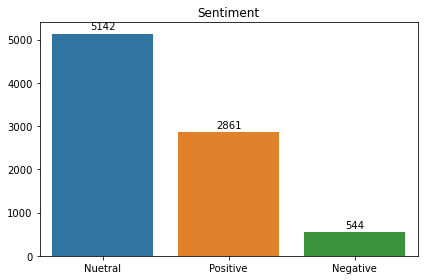

In [24]:
fig, ax = plt.subplots()

#Create x and y
x = df['sentiment'].value_counts().index
y = df['sentiment'].value_counts().values

#Plot the barchart
ax = sns.barplot(x,y)

#Set title
ax.set_title('Sentiment')

plt.ticklabel_format(style = 'plain', axis = 'y')

#This loop allows for lables on the bars
for p in ax.patches:
 # get the height of each bar
 height = p.get_height()
 # adding text to each bar
 ax.text(x = p.get_x()+(p.get_width()/2), # x-coordinate position of data label, padded to be in the middle of the bar
 y = height+100, # y-coordinate position of data label, padded 100 above bar
 s = '{:.0f}'.format(height), # data label, formatted to ignore decimals
 ha = 'center') # sets horizontal alignment (ha) to center
    
plt.tight_layout()
#fig.savefig('images/outcome_classes.png');

#### How are the length of the tweets distributed?

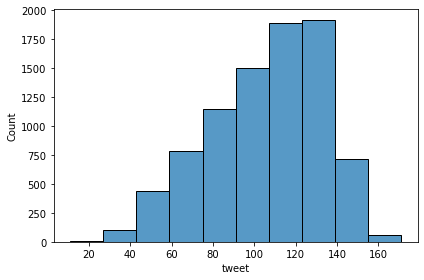

In [26]:
fig, ax = plt.subplots()

ax = sns.histplot(df['tweet'].str.len(), bins=10)

plt.tight_layout()
#fig.savefig('images/character_hist.png');

#### How many words are in the tweets?

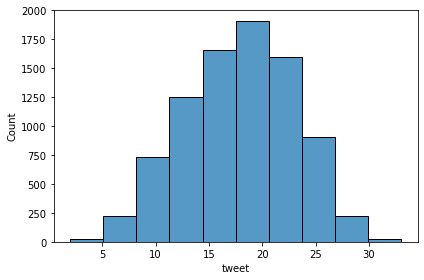

In [27]:
fig, ax = plt.subplots()

ax = sns.histplot(df['tweet'].str.split().map(lambda x: len(x)), bins=10)

plt.tight_layout()
#fig.savefig('images/word_hist.png');

#### What are the most common stop words?

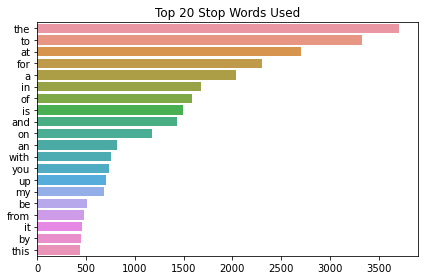

In [30]:
fig, ax = plt.subplots()

df['tweet'] = df['tweet'].astype(str)

corpus=[]
new= df['tweet'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

from collections import defaultdict

dic=defaultdict(int)
for word in corpus:
    if word in stop_words:
        dic[word]+=1
        
top25 = sorted(dic.items(), key=lambda item: item[1], reverse=True)[:20]

y_val = [x[0] for x in top25]
x_val = [x[1] for x in top25]

ax = sns.barplot(x_val,y_val, orient='h')
ax = ax.set_title('Top 20 Stop Words Used')

plt.tight_layout()
#fig.savefig('images/stopwords.png');

# Preprocess for modeling

In [37]:
df['tweet'] = df['tweet'].astype(str)

In [38]:
def preprocess_tweet_text(tweet):
    # Lowercase
    tweet = tweet.lower()
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#','', tweet)
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    tweet_tokens = word_tokenize(tweet)
    filtered_words = [w for w in tweet_tokens if not w in stop_words]
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in filtered_words]
    #Return the words joined back together
    return " ".join(lemma_words)

In [42]:
df['tweet'] = df['tweet'].apply(preprocess_tweet_text)

## Vectorize

In [43]:
# Convert string labels to 0,1,2
le = LabelEncoder()
df['target'] = le.fit_transform(df['sentiment'])

In [44]:
# Separate features and labels 
X = df['tweet']
y = df['target']

In [45]:
# Create test and train datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1)

In [48]:
#Instantiate TFIDF vectorizer
vectorizer = TfidfVectorizer()
#Fit transform training data
tf_idf_train = vectorizer.fit_transform(X_train)
#Transform test data
tf_idf_test = vectorizer.transform(X_test)

# Modeling

### Dummy Model

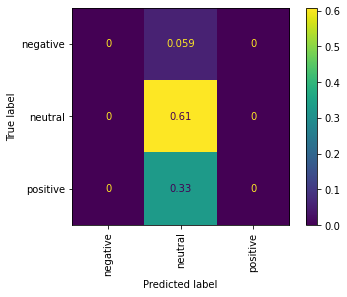

In [49]:
plot_confusion_matrix(DummyClassifier(strategy="most_frequent").fit(tf_idf_train , y_train), tf_idf_test, y_test, xticks_rotation='vertical', normalize = 'all', display_labels = ['negative', 'neutral', 'positive']);

### Baseline - FSM Model

In [51]:
rf = RandomForestClassifier(random_state=42)
#fit on training data
rf.fit(tf_idf_train, y_train)
#get predictions
y_preds_train = rf.predict(tf_idf_train)
y_preds_test = rf.predict(tf_idf_test)

#### Training Predictions

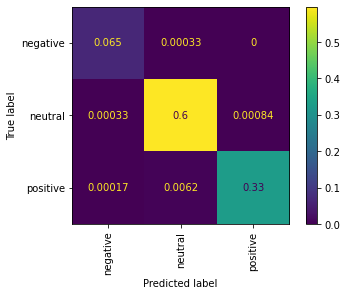

In [52]:
plot_confusion_matrix(rf, tf_idf_train, y_train, xticks_rotation='vertical', normalize='all', display_labels = ['negative', 'neutral', 'positive']);

#### Testing Predictions

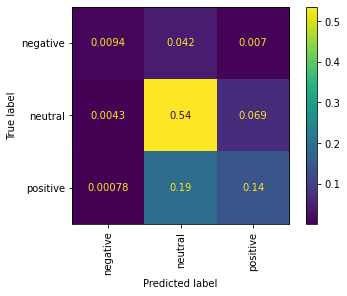

In [53]:
plot_confusion_matrix(rf, tf_idf_test, y_test, xticks_rotation='vertical', normalize='all', display_labels = ['negative', 'neutral', 'positive']);

### More models using Hyperparameter Tuning and Pipelines

In [54]:
# Naive Bayes pipeline setup
nb_pipe = Pipeline([
 ('tvec', TfidfVectorizer()),
 ('SMOTE',SMOTE(sampling_strategy = 'minority', random_state=42)),
 ('mnb', MultinomialNB())
])

# Randomforest pipeline setup
rf_pipe = Pipeline([
 ('tvec', TfidfVectorizer()),
 ('SMOTE', SMOTE(sampling_strategy = 'minority', random_state=42)),
 ('rf', RandomForestClassifier())
])

# Fit
nb_pipe.fit(X_train, y_train)
rf_pipe.fit(X_train, y_train)

# Setting params for TFIDF Vectorizer gridsearch
nb_params = {
 'tvec__max_features':[100, 500, 1000, 2000],
 'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
 'tvec__stop_words': ['english']
}

# Setting up randomforest params
rf_params = {
 'tvec__max_features':[500, 1000, 2000],
 'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
 'tvec__stop_words': ['english'],
 'rf__max_depth': [500, 1000],
 'rf__min_samples_split': [50,100]
}

In [55]:
start = time.time()

# Setting up GridSearch for Randomforest
rf_gs = GridSearchCV(rf_pipe, 
                     param_grid=rf_params, 
                     cv = 5, 
                     verbose = 1, 
                     n_jobs = -1)

# Setting up GridSearch for NB
nb_gs = GridSearchCV(nb_pipe, 
                     param_grid=nb_params, 
                     cv = 5, 
                     verbose =1, 
                     n_jobs = -1)

# Fitting NB GS
nb_gs.fit(X_train, y_train)

# Fitting Randomforest
rf_gs.fit(X_train, y_train)

end = time.time()
print('Time it took to run the fittings: {}'.format(round(end-start),0) + ' seconds')

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   40.5s finished


Time it took to run the fittings: 45 seconds


In [56]:
# Scoring Training data on NB
print('Training score for Naive Bayes: {}'.format(nb_gs.score(X_train, y_train)))

# Scoring Test data on NB
print('Testing score for Naive Bayes: {}'.format(nb_gs.score(X_test, y_test)))

# Scoring Training data on RandomForest
print('Training score for Random Forest: {}'.format(rf_gs.score(X_train, y_train)))

# Checking Test score on RandomForest
print('Testing score for Random Forest: {}'.format(rf_gs.score(X_test, y_test)))

Training score for Naive Bayes: 0.6965897693079238
Testing score for Naive Bayes: 0.5894736842105263
Training score for Random Forest: 0.9277833500501504
Testing score for Random Forest: 0.6651072124756335


# Final Model Evaluation

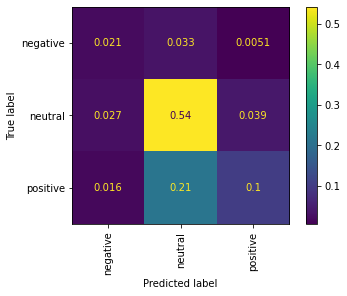

In [57]:
plot_confusion_matrix(rf_gs, X_test, y_test, xticks_rotation='vertical', normalize='all', display_labels = ['negative', 'neutral', 'positive']);

### Feature importance

In [105]:
#Find importances
title = pd.DataFrame(rf_pipe.steps[2][1].feature_importances_, rf_pipe.steps[0][1].get_feature_names(), columns=['importance'])
title = title.sort_values('importance', ascending = False).head(10)
title

,importance
link,0.026237
sxsw,0.019057
iphone,0.018319
ipad,0.016824
rt,0.014462
apple,0.010283
google,0.009418
app,0.008620
new,0.006813
store,0.006797


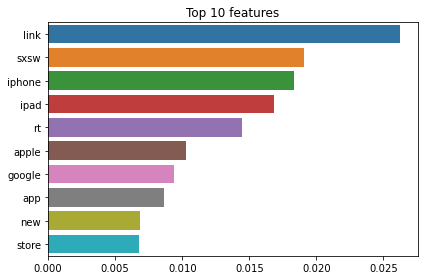

In [104]:
fig, ax = plt.subplots()

y = [x for x in title.index]
x = [y for i in title.values for y in i]

ax = sns.barplot(x, y, orient = 'h')
ax = ax.set_title('Top 10 features')

plt.tight_layout()
#fig.savefig('images/feature_importance.png');

# Conclusions

**1. 1st conclusion .**  

**2. 2nd conclusion.** 

**3. 3rd conclusion.** 

# Next Steps

Further analyses could provide even more insight into how we can predict the sentiment of tweets: 

**Next step** 

**Next step** 

**Next step** 